# Introduction
In this tutorial we're going to build a finite-state-machine (FSM) from scratch, using Silicon.
This will showcase a few important benefits of the Silicon framework compared to all other RTLs I'm aware of as well as give you a flavor of what's possible.
Later, I'll explain how (and why) the built-in state-machine implementation of Silicon is different from what is shown here.


# What is an FSM?
I'm not going to go into too much details about finite-state-machines, if you need an introduction, maybe the [Wikipedia page](https://en.wikipedia.org/wiki/Finite-state_machine) is a good starting point.

In digital logic, we use FSMs for implementing sequential logic, and in recent years, almost exclusively, synchronous sequential logic. This is the context in which we are going to work as well.

FSMs implement a set of states and a set of state-transitions. These state-transitions depend on both the current state of the machine as well as external stimuli. The transition happens when a 'clock' signals. Pretty simple.

In the literature, there are two main types of FSMs mentioned:
1. Mealy machines, which have an output that that depends on both the current state of the FSM as well as the input signals.
2. Moore machines, which present their current state as their output.

Here we're going to implement a Moore machine, but we will expose not only the current state, but the 'next state' as outputs. This allows for simple implementation of a Mealy type machine by attaching some combinational logic externally to the FSMs outputs.



TODO: add diagram!!

# How to describe an FSM?
In RTL (in fact in most programming languages) FSMs are usually described as a case statement, where each case contains a set of if-then-else statements. Here's one example from [here](https://inst.eecs.berkeley.edu/~cs150/sp12/resources/FSM.pdf):

```always@ ( * ) begin
	NextState = CurrentState;
	case ( CurrentState )
		STATE_Initial : begin
			NextState = STATE_1;
		end
		STATE_1 : begin
			if ( A & B ) NextState = STATE_2;
		end
		STATE_2 : begin
			if ( A ) NextState = STATE_3;
		end
		STATE_3 : begin
			if (! A & B ) NextState = STATE_Initial;
			else if ( A & ! B ) NextState = STATE_4;
		end
		STATE_4 : begin
		end
		// ---------------------------------------
		// Place - holder transitions
		// ---------------------------------------
		STATE_5_PlaceHolder : begin
			NextState = STATE_Initial;
		end
		STATE_6_PlaceHolder : begin
			NextState = STATE_Initial;
		end
		STATE_7_PlaceHolder : begin
			NextState = STATE_Initial;
		end
		// ---------------------------------------
	endcase
end
```

This actually only shows combinational part (the logic before the register), but you get the idea.

There is another way of describing a state-machine, which is using a transition diagram.

<<<TODO: add diagram>>>

In this case, the focus is on the conditions under which various transitions happen.

Of course the two descriptions are identical and the transformation from one to the other is not terribly difficult, can be confusing.

Would it be nice if we could write our FSMs in a way that is as close to these diagrams as a text representation could be?

Maintenance is another problem: there are many many ways of describing a state-machine in RTL:
- one can use case statements
- one could use if statements
- one could use conditional operators (?: in SystemVerilog)
- one could use a synchronous block for both the logic and the register or two different blocks

There are probably other variations I haven't even though of. If there was a unified way of dealing with this within the language, that would make reading and maintaining someone else's code so much easier.

# The prerequisites
Before we can start, let's set up Silicon

In [15]:
# This is needed for local setups only so Python finds Silicon 
import sys
sys.path.append("..")

from silicon import *

# Basic ideas
Let's get to work and try to figure out what we would want to do!

The idea would be that the state-machine is represented - instead of a bunch of expressions embedded in a larger module - by a module instance alone.

This module, let's call it MyFSM (why, will be clear by the end of the tutorial)! This module would need to be flexible enough to describe all FSMs we might want to implement.

It should also have a nice interface to describe both the states as well as the state-transitions.

Finally, it should be easy to embed it in a larger framework, that is to say, it's instantiation should be simple.

Let's start with the intended use-case! It would be nice if we could do something, like this:

In [2]:
class ModuleThatUsesAnFSM(Module):
    def body(self):
        fsm = MyFsm()
        
        # Do something with the state:
        self.my_output = SomeLogic(fsm.state)

Of course, this is not enough. We would have to somehow describe both the states, the FSM can have as well as its state-transitions, which of course should depend on some inputs.

State-transitions have the following generic format: if in <state A> and <condition> is true go to <state B>.

Wouldn't it be nice, if we could augment the previous code with something like this?

In [3]:
class ModuleThatUsesAnFSM(Module):
    def body(self):
        fsm = MyFsm()

        # Add some state-transitions
        fsm.add_transition(state_A, some_condition, state_B)
        # Do something with the state:
        self.my_output = SomeLogic(fsm.state)

Let's try to make this happen!

# The MyFSM module

Let's start by declaring a module. We want this module to have a clock and a reset port, with an optional reset value as well. These are the same ports that a Reg object has, which we'll need for getting the 'register' part of the FSM work anyways.

In [4]:
class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()

This of course doesn't do much yet. The next step is to create the method for adding state-transitions, we've called `add_transition` above.

What is important to realize here is that we can't really fill in the guts of MyFSM right in add_transition. There are two reasons for it. One is that `add_transition` can be called many many times in arbitrary order, so we can't really know if new state-transitions will be added. The second is that `add_transition` is called from the body of the module that instantiates MyFSM, which is not the right context to create sub-modules inside MyFSM: those would need to happen inside the body method of MyFSM.

So, we'll need to somehow store the 'configuration' of the FSM as it is described by the various `add_transition` calls, store that inside MyFSM and use that info in the body method.

I chose to store the state transitions in a dict-of-dicts. The outer dictionary associates starting, or current states to a set of state-transitions, originating from that state. The inner dict would associate an end-state with a condition.

Let's call this construct `_state_transition_table`.

The previous description essentially boils down to this: `_state_transition_table[<state A>][<state B>] = <condition>` describes a state transition from A to B of 'condition' is met.

Building this structure within `add_transition` is not that difficult:

In [5]:
class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()

    def construct(self) -> None:
        self._state_transition_table = OrderedDict()

    def add_transition(self, current_state: Any, condition: Port, new_state: Any) -> None:
        if current_state not in self._state_transition_table:
            self._state_transition_table[current_state] = OrderedDict()
        if new_state in self._state_transition_table[current_state]:
            raise SyntaxErrorException(f"State transition from {current_state} to {new_state} already exists in FSM {self}")
        port_name = f"input_{current_state}_to_{new_state}"
        input = Input()
        setattr(self, port_name, input)
        input <<= condition
        self._state_transition_table[current_state][new_state] = input


A few comments are called for on this piece of code.

We have to create a new `Input` port to accept the condition: The condition we feed to the module is in terms of an expression, which boils down to a piece of logic. This logic eventually terminates on an output port. This output power 'lives' in the context of the instantiation point, so we can't directly use it: we have to create an input and 'feed' the value through it. So really, the `_state_transition_table` contains the reference to our own freshly minted input port, and not directly to the condition.

This input is bound to the actual condition port and, using the `setattr` call, assigned a name as well as added to the MyFSM instance dynamically.

You already see here several things that are not normally possible in RTL languages, be it SystemVerilog or VHDL:
1. We can introduce behaviors to modules though the introduction of new methods to module classes. 
2. Not only that, we are dynamically changing the *interface* of the module *instance* based on method calls on it. This is not even close to what generics allow in any of those languages.

At this point the parent module, instantiating our FSM could create all the required state-transitions, by simply calling `add_transition` as many times as needed.

Now, we can start focusing on the guts of our FSM: the `body()` method. We will follow the traditional implementation: an outer 'case' statement with a bunch of inner 'if' statements. In Silicon, these constructs map to variants of 'Select' group of modules. The pseudo-code we want to see should look something like this:

In [6]:
def body(self):
    next_state <<= SelectOne(
        current_state == state_A, SelectOne(
            condition_A, state_A,
            condition_B, state_B
        ),
        current_state == state_B, SelectOne(
            condition_C, state_B,
            condition_D, state_A
        )
    )

Our problem though is that we have the various selector and value inputs to these modules stored in the `_state_transition_table` member. Here we can take advantage of Pythons support for dynamically binding function call parameters to arguments. All we need to do is to create a list (or tuple) of all the arguments we want to pass to `SelectOne` and use the special `*` syntax to call the function. With that idea in mind, we can crawl the `_state_transition_table` data-structure, create these lists and pass them to the appropriate calls: 

In [7]:
class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()

    def construct(self) -> None:
        self._state_transition_table = OrderedDict()

    def add_transition(self, current_state: Any, condition: Port, new_state: Any) -> None:
        if current_state not in self._state_transition_table:
            self._state_transition_table[current_state] = OrderedDict()
        if new_state in self._state_transition_table[current_state]:
            raise SyntaxErrorException(f"State transition from {current_state} to {new_state} already exists in FSM {self}")
        port_name = f"input_{current_state}_to_{new_state}"
        input = Input()
        setattr(self, port_name, input)
        input <<= condition
        self._state_transition_table[current_state][new_state] = input

    def body(self) -> None:
        # Variables holding the current and the next state
        local_state = Wire()
        local_next_state = Wire()

        # Generate the outer (current state) and inner (next state) selectors
        next_state_args = []
        for current_state, edges in self._state_transition_table.items():
            args = []
            for new_state, condition_port in edges.items():
                args += (condition_port, new_state)
            condition_selector = SelectOne(*args)
            next_state_args += (local_state == current_state, condition_selector)
        local_next_state <<= SelectOne(*next_state_args)


We of course are still missing two important features: we haven't exposed the current and next state of the FSM to the outside world, and we haven't actually crated the register holding the state. That is easy to rectify though:

In [8]:
class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()
    state = Output()
    next_state = Output()

    def construct(self) -> None:
        self._state_transition_table = OrderedDict()

    def add_transition(self, current_state: Any, condition: Port, new_state: Any) -> None:
        if current_state not in self._state_transition_table:
            self._state_transition_table[current_state] = OrderedDict()
        if new_state in self._state_transition_table[current_state]:
            raise SyntaxErrorException(f"State transition from {current_state} to {new_state} already exists in FSM {self}")
        port_name = f"input_{current_state}_to_{new_state}"
        input = Input()
        setattr(self, port_name, input)
        input <<= condition
        self._state_transition_table[current_state][new_state] = input

    def body(self) -> None:
        # Variables holding the current and the next state
        local_state = Wire()
        local_next_state = Wire()

        # Generate the outer (current state) and inner (next state) selectors
        next_state_args = []
        for current_state, edges in self._state_transition_table.items():
            args = []
            for new_state, condition_port in edges.items():
                args += (condition_port, new_state)
            condition_selector = SelectOne(*args)
            next_state_args += (local_state == current_state, condition_selector)
        local_next_state <<= SelectOne(*next_state_args)
        local_state <<= Reg(local_next_state)

        self.next_state <<= local_next_state
        self.state <<= local_state


Notice what's happening here: not only did we change the interface of the module dynamically, we are generating the body of the module using code as well. This is something that 'generate' statements are used for in Verilog, but their use is somewhat limited. The fact that we can construct argument lists, use loops and - essentially - all the richness of Python to meta-program the instantiation of the sub-modules of our FSM is way more flexible than provided by those languages.

At the same time, notice another thing: we are still only building a data-flow graph: our for loops are not 'converted' into RTL or unrolled into gates. What they simply do is to script (or meta-program) the creation of the actual data-flow objects, in this case the SelectOne instances.

So far, so good, but it doesn't work, unfortunately. The reason for that is that there's a feedback-loop within the body of our FSM: the output of the register (`local_state`) influences what the value of `local_next_state` is going to be. Of course there's no surprise here, that's literally what FSM are for, but it poses a problem for the algorithm that tries to determine the types of all the ports and wires in our system.

In this particular case, it can't, at least not without our help.

We have to give it some starting point, for example by providing a type for local_state. But how? This is not information that is explicitly given to any MyFSM instance. We could however keep track of the minimum and maximum values of any state that is passed in to `add_transition`, and with the range-tracking feature of the Number type resolve this problem:

In [9]:
class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()
    default_state = Input()
    state = Output()
    next_state = Output()

    def construct(self) -> None:
        self._state_transition_table = OrderedDict()
        self._min_state_val = None
        self._max_state_val = None

    def add_transition(self, current_state: Any, condition: Port, new_state: Any) -> None:
        if self._min_state_val is None:
            self._min_state_val = min(current_state, new_state)
        else:
            self._min_state_val = min(self._min_state_val, current_state, new_state)
        if self._max_state_val is None:
            self._max_state_val = max(current_state, new_state)
        else:
            self._max_state_val = max(self._min_state_val, current_state, new_state)

        if current_state not in self._state_transition_table:
            self._state_transition_table[current_state] = OrderedDict()
        if new_state in self._state_transition_table[current_state]:
            raise SyntaxErrorException(f"State transition from {current_state} to {new_state} already exists in FSM {self}")
        port_name = f"input_{current_state}_to_{new_state}"
        input = Input()
        setattr(self, port_name, input)
        input <<= condition
        self._state_transition_table[current_state][new_state] = input

    def body(self) -> None:
        # Variables holding the current and the next state
        state_type = Number(min_val=self._min_state_val, max_val=self._max_state_val)
        local_state = Wire(state_type)
        local_next_state = Wire(state_type)

        # Generate the outer (current state) and inner (next state) selectors
        next_state_args = []
        for current_state, edges in self._state_transition_table.items():
            args = []
            for new_state, condition_port in edges.items():
                args += (condition_port, new_state)
            condition_selector = SelectOne(*args)
            next_state_args += (local_state == current_state, condition_selector)
        local_next_state <<= SelectOne(*next_state_args)
        local_state <<= Reg(local_next_state)

        self.next_state <<= local_next_state
        self.state <<= local_state


We can do a little better though: state machines have this nasty problem that not all possible states necessarily have state-transitions out of them. This is most likely due to the fact that the state-variable (the bits stored in the state-register) can have more possible values than the states required for the state-machine. If for whatever reason, the FSM enters one of those states (noise, cosmic rays, too many cats around, whatever), they will never get out of them. It would be nice to have a 'default state', the state-machine transitions into from any state, if no explicit transition is specified.

The side-effect of this design choice of course is that now, we have to explicitly describe the conditions under which we *don't want to* change state.

Since `SelectOne` modules already have a feature for a `default` port, that provides a default value if none of the input selectors are asserted, we simply have to provide a way to control what the value of those ports should be:

In [13]:
class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()
    default_state = Input()
    state = Output()
    next_state = Output()
    default_state = Input()

    def construct(self) -> None:
        self._state_transition_table = OrderedDict()
        self._min_state_val = None
        self._max_state_val = None

    
    def add_transition(self, current_state: Any, condition: Port, new_state: Any) -> None:
        if self._min_state_val is None:
            self._min_state_val = min(current_state, new_state)
        else:
            self._min_state_val = min(self._min_state_val, current_state, new_state)
        if self._max_state_val is None:
            self._max_state_val = max(current_state, new_state)
        else:
            self._max_state_val = max(self._min_state_val, current_state, new_state)

        if current_state not in self._state_transition_table:
            self._state_transition_table[current_state] = OrderedDict()
        if new_state in self._state_transition_table[current_state]:
            raise SyntaxErrorException(f"State transition from {current_state} to {new_state} already exists in FSM {self}")
        port_name = f"input_{current_state}_to_{new_state}"
        input = Input()
        setattr(self, port_name, input)
        input <<= condition
        self._state_transition_table[current_state][new_state] = input

    def body(self) -> None:
        # Variables holding the current and the next state
        state_type = Number(min_val=self._min_state_val, max_val=self._max_state_val)
        local_state = Wire(state_type)
        local_next_state = Wire(state_type)

        # Generate the outer (current state) and inner (next state) selectors
        next_state_args = []
        for current_state, edges in self._state_transition_table.items():
            args = []
            for new_state, condition_port in edges.items():
                args += (condition_port, new_state)
            condition_selector = SelectOne(*args, default = self.default_state)
            next_state_args += (local_state == current_state, condition_selector)
        local_next_state <<= SelectOne(*next_state_args, default = self.default_state)
        local_state <<= Reg(local_next_state)

        self.next_state <<= local_next_state
        self.state <<= local_state

This took a while, but we did it! Now, it's time to put all the pieces together with a use-case that will also serve as our minimalistic test-bench.

# The checksum module
Let's tackle something, not too complicated, but not trivial either! Let's say, we want to implement a checksum module. It has an input, which in each clock-cycle may present a new byte to be added to the checksum. We'll call it `data_in`. A qualification input (`data_in_valid`) will tell us if the data is indeed valid for that clock_cycle. The summation should terminate when the `data_last` input is asserted, at which point we'll provide the checksum on `data_out` and signal its validity by asserting `data_out_valid`.

There are five states of the system (six, if the reset state is counted as well):

    reset = 0
    idle = 1
    get_data = 2
    get_wait = 3
    get_first_data = 4
    send_data = 5

The state transitions are as follows:

<<<TODO: add state-diagram>>>

This takes care of the control-plane. The data-plane is rather simple and contains an 8-bit accumulator. To reduce the latency of the system, the data-plane depends on the *next state* of the control-plane as opposed to the current state. This of course is a choice that can change from design to design, in this case however, I'll go with this approach.

The operation of the data-plane based on the next state of the control-plane is as follows:



<<<TODO: add state-diagram>>>

With all that, we're now ready to code up the checksum module (and it's test-bench):

In [11]:
class Checksum(Module):
    # We're implementing a simple checksum module: get inputs until 'last', then output the sum of all received inputs
    clk = ClkPort()
    rst = RstPort()

    data_in_valid = Input(logic)
    data_last = Input(logic)
    data_in = Input(Unsigned(8))
    data_out = Output(Unsigned(8))
    data_out_valid = Output(logic)

    def body(self) -> None:
        my_fsm = MyFSM()
        self.my_fsm = my_fsm # Will need it during generate to save PDF

        class States(object):
            reset = 0
            idle = 1
            get_data = 2
            get_wait = 3
            get_first_data = 4
            send_data = 5

        my_fsm.reset_value <<= States.reset
        my_fsm.default_state <<= States.idle

        # You don't have to list transitions in any particular order. Do what makes sense for you
        my_fsm.add_transition(States.reset, 1, States.idle) # Always enter idle from reset
        my_fsm.add_transition(States.idle, self.data_in_valid & ~self.data_last, States.get_first_data)
        my_fsm.add_transition(States.get_data, ~self.data_in_valid, States.get_wait)
        my_fsm.add_transition(States.get_data, self.data_in_valid & ~self.data_last, States.get_data)
        my_fsm.add_transition(States.get_wait, ~self.data_in_valid, States.get_wait)
        my_fsm.add_transition(States.get_wait, self.data_in_valid & ~self.data_last, States.get_data)
        my_fsm.add_transition(States.get_data, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.get_wait, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.idle, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.send_data, ~self.data_in_valid, States.idle)
        my_fsm.add_transition(States.send_data, self.data_in_valid & ~self.data_last, States.get_first_data)
        my_fsm.add_transition(States.send_data, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.get_first_data, ~self.data_in_valid, States.get_wait)
        my_fsm.add_transition(States.get_first_data, self.data_in_valid & ~self.data_last, States.get_data)
        my_fsm.add_transition(States.get_first_data, self.data_in_valid & self.data_last, States.send_data)

        my_sum = Wire(Unsigned(8))
        next_my_sum = Wire(Unsigned(8))
        next_my_sum <<= SelectOne(
            my_fsm.next_state == States.reset, 0,
            my_fsm.next_state == States.idle, 0,
            my_fsm.next_state == States.get_first_data, self.data_in,
            my_fsm.next_state == States.get_data, (my_sum + self.data_in)[7:0],
            my_fsm.next_state == States.get_wait, my_sum,
            my_fsm.next_state == States.send_data, (my_sum + self.data_in)[7:0]
        )
        my_sum <<= Reg(next_my_sum)
        self.data_out <<= my_sum
        self.data_out_valid <<= my_fsm.state == States.send_data

def checksum_gen():
    top = Checksum()
    netlist = elaborate(top)
    rtl = StrStream()
    netlist.generate(netlist, SystemVerilog(rtl))
    print(rtl)

#######################################################################
# Test-bench
#######################################################################

def checksum_sim():
    class Checksum_tb(Checksum):
        def simulate(self):
            def clk() -> int:
                yield 10
                self.clk <<= ~self.clk
                yield 10
                self.clk <<= ~self.clk
                yield 0
            
            def send_packet(byte_cnt: int, wait_cnt: int, initial_sum: int = 0):
                from random import randint
                chksum = initial_sum
                for idx in range(byte_cnt):
                    data = randint(0, 255)
                    chksum += data
                    last = idx == byte_cnt - 1
                    self.data_in <<= data
                    self.data_in_valid <<= 1
                    self.data_last <<= last
                    yield from clk()
                    if not last:
                        for wait in range(wait_cnt):
                            self.data_in_valid <<= 0
                            yield from clk()
                self.data_in_valid <<= 0
                self.expected_checksum = chksum & 255

            print("Simulation started")
            self.rst <<= 1
            self.clk <<= 1
            yield 10
            for i in range(5):
                yield from clk()
            print("Reset removed")
            self.rst <<= 0
            for i in range(5):
                yield from clk()

            yield from send_packet(5,0)
            yield from clk()
            assert self.data_out_valid == 1
            assert self.data_out == self.expected_checksum

            for i in range(5):
                yield from clk()

            yield from send_packet(1,0)
            yield from clk()
            assert self.data_out_valid == 1
            assert self.data_out == self.expected_checksum
            yield from send_packet(3,0)
            yield from clk()
            assert self.data_out_valid == 1
            assert self.data_out == self.expected_checksum
            yield from send_packet(4,0)
            self.data_in <<= 33
            self.data_in_valid <<= 1
            self.data_last <<= 0
            yield from clk()
            assert self.data_out_valid == 1
            assert self.data_out == self.expected_checksum
            yield from send_packet(5,0,33)
            yield from clk()
            assert self.data_out_valid == 1
            assert self.data_out == self.expected_checksum
            yield from send_packet(5,4)
            yield from clk()
            assert self.data_out_valid == 1
            assert self.data_out == self.expected_checksum
            print("Simulation ended")

    top = UseFSM_tb()
    netlist = elaborate(top)
    vcd_filename = "checksum.vcd"
    netlist.simulate(vcd_filename)

if __name__ == "__main__":
    checksum_gen()
    #checksum_sim()

////////////////////////////////////////////////////////////////////////////////
// Checksum
////////////////////////////////////////////////////////////////////////////////
module Checksum (
	input logic clk,
	input logic rst,
	input logic data_in_valid,
	input logic data_last,
	input logic [7:0] data_in,
	output logic [7:0] data_out,
	output logic data_out_valid
);

	logic [2:0] my_fsm_next_state;
	logic [2:0] my_fsm_state;
	logic [7:0] next_my_sum;
	logic [7:0] my_sum;

	assign next_my_sum = my_fsm_next_state == 1'h0 ? 1'h0 : 8'b0 | my_fsm_next_state == 1'h1 ? 1'h0 : 8'b0 | my_fsm_next_state == 3'h4 ? data_in : 8'b0 | my_fsm_next_state == 2'h2 ? (my_sum + data_in)[7:0] : 8'b0 | my_fsm_next_state == 2'h3 ? my_sum : 8'b0 | my_fsm_next_state == 3'h5 ? (my_sum + data_in)[7:0] : 8'b0 | 'X;
	always_ff @(posedge clk) my_sum <= rst ? 8'b0 : next_my_sum;
	assign data_out_valid = my_fsm_state == 3'h5;

	MyFSM my_fsm (
		.clock_port(clk),
		.reset_port(rst),
		.reset_value(1'h0),
		.default_st

TODO: fix tracer such that we don't need the . This is getting ridiculous!!!!

# But wait, there's more!
I hope at this point you are convinced of the power of Silicon's approach to RTL: we've managed the library with a component that abstracts away all the complexities of creating state-machines. It provides a unified, simple-to-write and more importantly simple-to-read abstraction. We didn't need new keywords, didn't need to add anything to the language to accomplish this.

But now that I've vet your appetite, let's do something really cool! What if we could get our FSM to generate pretty state-transition diagrams automatically. Can we do that?

Of course we can! After all, this is all 'just' Python. It's a bit more involved, and requires a deeper understanding of the inner workings of Silicon, but it's certainly doable:

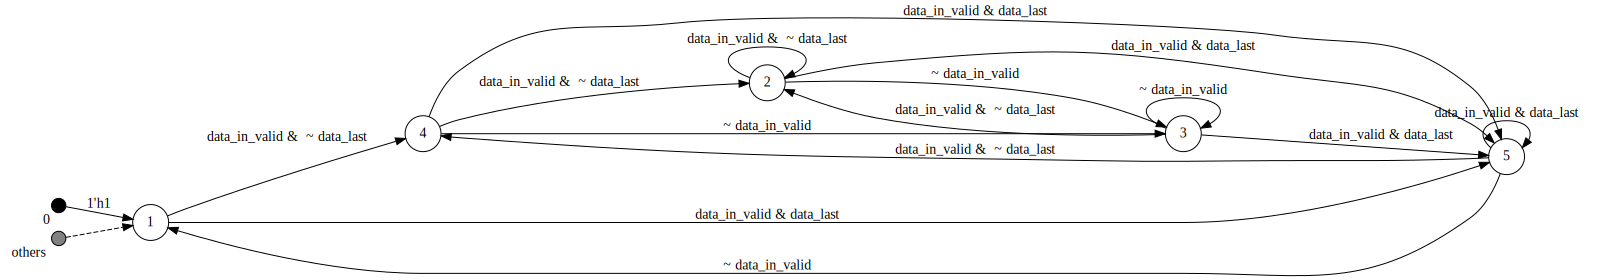

In [12]:
# This is needed for local setups only so Python finds silicon 
import sys
sys.path.append("..")

from silicon import *

class MyFSM(Module):
    clock_port = ClkPort()
    reset_port = RstPort()
    reset_value = RstValPort()
    default_state = Input()
    state = Output()
    next_state = Output()
    default_state = Input()

    def construct(self) -> None:
        self._state_transition_table = OrderedDict()
        self._min_state_val = None
        self._max_state_val = None

    
    def add_transition(self, current_state: Any, condition: Port, new_state: Any) -> None:
        if self._min_state_val is None:
            self._min_state_val = min(current_state, new_state)
        else:
            self._min_state_val = min(self._min_state_val, current_state, new_state)
        if self._max_state_val is None:
            self._max_state_val = max(current_state, new_state)
        else:
            self._max_state_val = max(self._min_state_val, current_state, new_state)

        if current_state not in self._state_transition_table:
            self._state_transition_table[current_state] = OrderedDict()
        if new_state in self._state_transition_table[current_state]:
            raise SyntaxErrorException(f"State transition from {current_state} to {new_state} already exists in FSM {self}")
        port_name = f"input_{current_state}_to_{new_state}"
        input = Input()
        setattr(self, port_name, input)
        input <<= condition
        self._state_transition_table[current_state][new_state] = input

    def body(self) -> None:
        # Variables holding the current and the next state
        state_type = Number(min_val=self._min_state_val, max_val=self._max_state_val)
        local_state = Wire(state_type)
        local_next_state = Wire(state_type)

        # Generate the outer (current state) and inner (next state) selectors
        next_state_args = []
        for current_state, edges in self._state_transition_table.items():
            args = []
            for new_state, condition_port in edges.items():
                args += (condition_port, new_state)
            condition_selector = SelectOne(*args, default = self.default_state)
            next_state_args += (local_state == current_state, condition_selector)
        local_next_state <<= SelectOne(*next_state_args, default = self.default_state)
        local_state <<= Reg(local_next_state)

        self.next_state <<= local_next_state
        self.state <<= local_state

    def draw(self, scope: Module, netlist: 'Netlist', back_end: 'BackEnd') -> 'Digraph':
        from graphviz import Digraph

        f = Digraph(name = self._impl.get_diagnostic_name())

        f.attr(rankdir='LR')

        # Try to figure out the reset port
        #TODO: FIXME: we should use XNets here!!!
        reset_source = self.reset_value.source
        while reset_source.source is not None:
            reset_source = reset_source.source
        if reset_source is not None and hasattr(reset_source.get_parent_module(), "constant"):
            reset_value = reset_source.get_parent_module().constant.value
            f.node(name=str(reset_value), xlabel=str(reset_value), shape="point", height="0.2")

        # Try to figure out the default port
        default_source = self.default_state.source
        while default_source.source is not None:
            default_source = default_source.source
        if default_source is not None and hasattr(default_source.get_parent_module(), "constant"):
            default_value = default_source.get_parent_module().constant.value
            f.node(name="__others__", xlabel="others", shape="point", fillcolor="gray", style="dashed", height="0.2")
            f.node(name=str(default_value), label=str(default_value), shape="circle")
            f.edge("__others__", str(default_value), style="dashed")

        f.attr('node', shape='circle')
        for current_state, edges in self._state_transition_table.items():
            for new_state, condition_port in edges.items():
                xnet = netlist.get_xnet_for_junction(condition_port)
                condition_str, _ = xnet.get_rhs_expression(scope, back_end)
                f.edge(str(current_state), str(new_state), label=condition_str)
        return f

#######################################################################
# Checksum module
#######################################################################

class Checksum(Module):
    # We're implementing a simple checksum module: get inputs until 'last', then output the sum of all received inputs
    clk = ClkPort()
    rst = RstPort()

    data_in_valid = Input(logic)
    data_last = Input(logic)
    data_in = Input(Unsigned(8))
    data_out = Output(Unsigned(8))
    data_out_valid = Output(logic)

    def body(self) -> None:
        my_fsm = MyFSM()
        self.my_fsm = my_fsm # Will need it during generate to save PDF

        class States(object):
            reset = 0
            idle = 1
            get_data = 2
            get_wait = 3
            get_first_data = 4
            send_data = 5

        my_fsm.reset_value <<= States.reset
        my_fsm.default_state <<= States.idle

        # You don't have to list transitions in any particular order. Do what makes sense for you
        my_fsm.add_transition(States.reset, 1, States.idle) # Always enter idle from reset
        my_fsm.add_transition(States.idle, self.data_in_valid & ~self.data_last, States.get_first_data)
        my_fsm.add_transition(States.get_data, ~self.data_in_valid, States.get_wait)
        my_fsm.add_transition(States.get_data, self.data_in_valid & ~self.data_last, States.get_data)
        my_fsm.add_transition(States.get_wait, ~self.data_in_valid, States.get_wait)
        my_fsm.add_transition(States.get_wait, self.data_in_valid & ~self.data_last, States.get_data)
        my_fsm.add_transition(States.get_data, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.get_wait, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.idle, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.send_data, ~self.data_in_valid, States.idle)
        my_fsm.add_transition(States.send_data, self.data_in_valid & ~self.data_last, States.get_first_data)
        my_fsm.add_transition(States.send_data, self.data_in_valid & self.data_last, States.send_data)
        my_fsm.add_transition(States.get_first_data, ~self.data_in_valid, States.get_wait)
        my_fsm.add_transition(States.get_first_data, self.data_in_valid & ~self.data_last, States.get_data)
        my_fsm.add_transition(States.get_first_data, self.data_in_valid & self.data_last, States.send_data)

        my_sum = Wire(Unsigned(8))
        next_my_sum = Wire(Unsigned(8))
        next_my_sum <<= SelectOne(
            my_fsm.next_state == States.reset, 0,
            my_fsm.next_state == States.idle, 0,
            my_fsm.next_state == States.get_first_data, self.data_in,
            my_fsm.next_state == States.get_data, (my_sum + self.data_in)[7:0],
            my_fsm.next_state == States.get_wait, my_sum,
            my_fsm.next_state == States.send_data, (my_sum + self.data_in)[7:0]
        )
        my_sum <<= Reg(next_my_sum)
        self.data_out <<= my_sum
        self.data_out_valid <<= my_fsm.state == States.send_data
    def draw(self, netlist: 'Netlist', back_end: 'BackEnd') -> 'Digraph':
        return self.my_fsm.draw(self, netlist, back_end)
        
def draw_graph():
    top = Checksum()
    netlist = elaborate(top)
    rtl = StrStream()
    netlist.generate(netlist, SystemVerilog(rtl))
    return top.draw(netlist, SystemVerilog(rtl))    

draw_graph()

# In closing
Of course something as useful as FSMs should be part of the standard library, provided by Silicon and indeed they are. Silicon provides two FSM implementations.

One, called `FSMLogic` encompasses only the combinational logic in front of a register in a Moore FSM. This can be combined with a custom register implementation (such as a clock-enabled register) to create a complete FSM.

The other, called `FSM` additionally contains a register as well, very similarly to the one we've developed in this tutorial. The library-provided implementation also allows to replace the internal register instance (Reg by default) with another, user-provided one for added flexibility.

If you look at the library implementation, you will see a lot more code then what we've seen here, but that's just how libraries work: they need to do a lot more sanity-checks, cover usage corner-cases then a one-off tutorial as this one.

# TODO:
1. Clean up drawing: we shouldn't need to call generate on the netlist.
2. explain drawing (and maybe more cleanup): figure out how to make it more clean and generic. Maybe even a way to generate Python expressions instead of SV ones.
3. How should we handle Enums and state-names?
4. Relative to the above: if Enums are used, how can we auto-determine port types? What if we have mixed state-types?
5. Relative to the above: can we generate named states in VCD dumps?
6. Show example of simulation.